In [1]:
from itertools import product, accumulate

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, linregress

from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize, minmax_scale
from sklearn.linear_model import LinearRegression

from rdkit import Chem
from rdkit.Chem import AllChem, MolFromSmiles, MolToSmiles, MolToInchi, InchiToInchiKey, PandasTools
from rdkit.Chem.Draw import IPythonConsole
import rdkit.Chem.Descriptors as D

from tqdm import tqdm_notebook
%matplotlib inline
pd.set_option('display.max_columns', 500)

## Load the data

In [2]:
df_clean = pd.read_csv('secondary_data/df_clean.csv', index_col=0)
df_molecules_std = pd.read_csv('secondary_data/df_molecules_std.csv', index_col=0)
df_activity = pd.read_csv('secondary_data/df_activity.csv', index_col=0)

In [3]:
std_mols_clean = list(map(MolFromSmiles, df_molecules_std.std_smiles))

In [4]:
df_join = df_activity.join(df_molecules_std, on='std_inchi_key')

In [5]:
df_join.head(8)

,receptor_name,Standard_Value,std_smiles,std_inchi,std_morgan_fp,scaffold_morgan_fp,scaffold_smiles
std_inchi_key,,,,,,,
AAFYPWXCJRYVKV-ILTCGSTDSA-N,GR,0.89,C[C@]12C[C@H](O)[C@H]3[C@@H](CCC4=Cc5c(cnn5-c5...,InChI=1S/C34H36N4O4S/c1-32-16-20-18-36-38(22-7...,0000000000000000000100000100000001001000000100...,0000000000000000000100000100000000000000000100...,O=C(CSc1nc2ncccc2o1)C1CC[C@@H]2C1CC[C@@H]1C3Cc...
AAJNWJFLYOFHIB-UHFFFAOYSA-N,GR,17.00,COc1ccc(F)cc1C(C)(C)CC(O)(Cc1ccc(C#N)cc1Cl)C(F...,"InChI=1S/C21H20ClF4NO2/c1-19(2,16-9-15(23)6-7-...",0000000000000000000010000000000001000000000000...,0000000000000000000001000000000000000000001000...,c1ccc(CCCCc2ccccc2)cc1
AAJNWJFLYOFHIB-UHFFFAOYSA-N,MR,320.00,COc1ccc(F)cc1C(C)(C)CC(O)(Cc1ccc(C#N)cc1Cl)C(F...,"InChI=1S/C21H20ClF4NO2/c1-19(2,16-9-15(23)6-7-...",0000000000000000000010000000000001000000000000...,0000000000000000000001000000000000000000001000...,c1ccc(CCCCc2ccccc2)cc1
AAJNWJFLYOFHIB-UHFFFAOYSA-N,PR,140.00,COc1ccc(F)cc1C(C)(C)CC(O)(Cc1ccc(C#N)cc1Cl)C(F...,"InChI=1S/C21H20ClF4NO2/c1-19(2,16-9-15(23)6-7-...",0000000000000000000010000000000001000000000000...,0000000000000000000001000000000000000000001000...,c1ccc(CCCCc2ccccc2)cc1
AAPVCQWLJSSUGW-UHFFFAOYSA-N,AR,19000.00,Cc1ccccc1OCCSc1nc2ccccc2[nH]1,InChI=1S/C16H16N2OS/c1-12-6-2-5-9-15(12)19-10-...,0000000000000100000000000000000001000000000000...,0000000000100100000000000000000000000000000000...,c1ccc(OCCSc2nc3ccccc3[nH]2)cc1
AAQPJNXQFGYYCM-UHFFFAOYSA-N,ERa,38620.53,Cc1onc(-c2c(F)cccc2Cl)c1C(=O)OCC(=O)NCc1ccco1,InChI=1S/C18H14ClFN2O5/c1-10-15(17(22-27-10)16...,0000000010000001000000000000000001000000010000...,0000000000000000000000000000000000000000010000...,O=C(COC(=O)c1conc1-c1ccccc1)NCc1ccco1
AAUFIERBXVEOEY-UHFFFAOYSA-N,ERb,3133.78,O=C(Nc1ccc2c(c1)OCO2)c1cccc2c1C(=O)N(Cc1cccnc1)C2,InChI=1S/C22H17N3O4/c26-21(24-16-6-7-18-19(9-1...,0000000000010001000100000000000000000000001000...,0000000000010001000100000000000000000000001000...,O=C(Nc1ccc2c(c1)OCO2)c1cccc2c1C(=O)N(Cc1cccnc1)C2
AAYYOXKEPZBTIZ-UHFFFAOYSA-N,AR,43.00,COc1cc(Sc2c(C)cccc2C)ccc1C#N,InChI=1S/C16H15NOS/c1-11-5-4-6-12(2)16(11)19-1...,0000000000000001000000000000000001000000000000...,0000000000000000000000000001000000000000000000...,c1ccc(Sc2ccccc2)cc1


## Exploratory analysis

In [6]:
def plot_kde(x, num_points=1000, *args, **kwargs):
    density = gaussian_kde(x)
    x = np.linspace(np.min(x), np.max(x), num_points)
    plt.plot(x, density(x), *args, **kwargs)

In [7]:
def plot_kde_2d(p_x,p_y, num_points=100, bw_method=None, *args, **kwargs):
    density = gaussian_kde(np.c_[p_x, p_y].T, bw_method)
    x,y = np.linspace(np.min(p_x),np.max(p_x), num_points), np.linspace(np.min(p_y), np.max(p_y), num_points)
    z = density(np.asarray(list(product(x,y))).T).reshape(num_points,num_points).T
#     z = density(list(zip(*product(x,y)))).reshape(num_points,num_points).T
    plt.pcolormesh(x,y,z, *args, **kwargs)

In [8]:
from matplotlib import cm

def make_colormap(x, colormap=cm.plasma):
    return colormap(np.int64(minmax_scale(x)*255))

def plot_scatter_colormap(x,y,z,alpha=0.25,*args,**kwargs):
#     plt.figure()
    plt.scatter(x,y, c=make_colormap(z), alpha=alpha, *args, **kwargs)
    plt.figure()
    plt.axis('off')
    plt.imshow(np.expand_dims(np.asarray(cm.plasma.colors),0),aspect=10)

In [9]:
def plot_linear_regression(x,y,alpha=0.1,*args,**kwargs):
    lr = linregress(x,y)
    plt.scatter(x, y, alpha=alpha,*args,**kwargs)
    min_x = np.min(x)
    max_x = np.max(x)
    line_x = np.asarray([min_x, max_x])
    line_y = lr.intercept + lr.slope*line_x
    plt.plot(line_x, line_y, '--', c='black')
    plt.title('r=%.3f, p=%e, stderr=%.3f' % (lr.rvalue, lr.pvalue, lr.stderr))

Text(0.5, 1.0, 'Number of atoms (log10)')

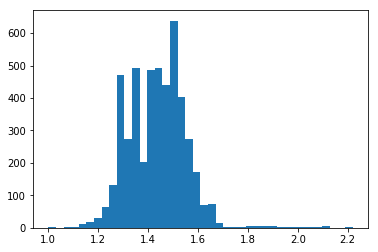

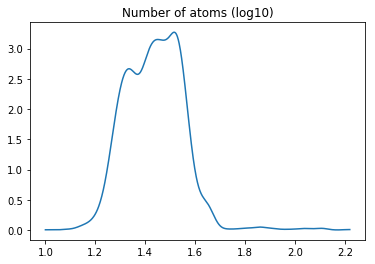

In [10]:
plt.hist(np.log10([x.GetNumAtoms() for x in std_mols_clean]), bins=40)
plt.figure()
plot_kde(np.log10([x.GetNumAtoms() for x in std_mols_clean]))
plt.title('Number of atoms (log10)')

Text(0.5, 1.0, 'Standard value (log10)')

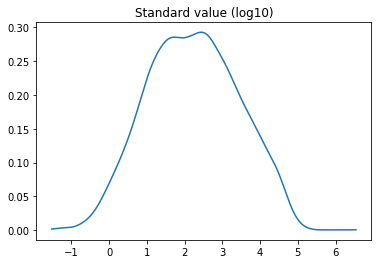

In [11]:
plot_kde(np.log10(df_activity.Standard_Value))
plt.title('Standard value (log10)')

Text(0.5, 1.0, 'Length of smiles (log10)')

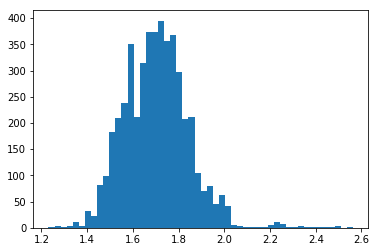

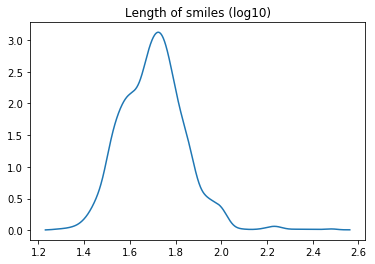

In [12]:
plt.hist(np.log10(list(map(len,df_molecules_std.std_smiles))), bins=50)
plt.figure()
plot_kde(np.log10(list(map(len,df_molecules_std.std_smiles))))
plt.title('Length of smiles (log10)')

Text(0.5, 1.0, 'Standard value vs length of smiles (log-log)')

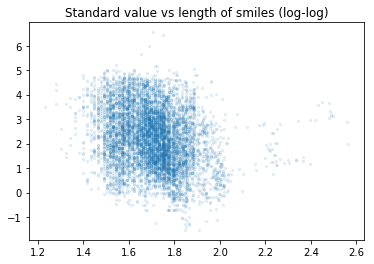

In [13]:
plt.scatter(np.log10(list(map(len,df_join.std_smiles))), np.log10(df_join.Standard_Value), alpha=0.1, s=5)
plt.title('Standard value vs length of smiles (log-log)')

Text(0.5, 1.0, 'Standard value vs length of smiles (log-log)')

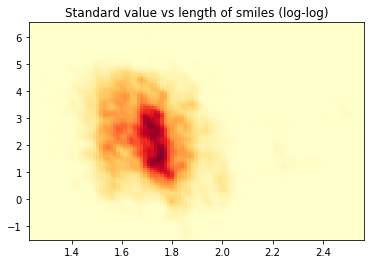

In [14]:
plot_kde_2d(np.log10(list(map(len,df_join.std_smiles))), np.log10(df_join.Standard_Value), num_points=100, bw_method=0.1, cmap='YlOrRd')
plt.title('Standard value vs length of smiles (log-log)')

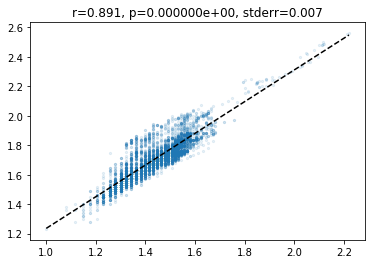

In [15]:
plot_linear_regression(np.log10([MolFromSmiles(x).GetNumAtoms() for x in df_join.std_smiles]), np.log10(list(map(len,df_join.std_smiles))), alpha=0.1, s=5)
# plt.title('Length of smiles vs Number of atoms (log-log)')

## Analysis of ERa ligands

In [16]:
df_era = df_join.query('receptor_name == "ERa"').copy()

In [17]:
df_era['active'] = df_era.Standard_Value < 100

In [18]:
fps          = np.asarray([np.frombuffer(fp.encode('ASCII'), np.byte) - ord('0') for fp in df_era.std_morgan_fp])
scaffold_fps = np.asarray([np.frombuffer(fp.encode('ASCII'), np.byte) - ord('0') for fp in df_era.scaffold_morgan_fp])

In [19]:
log_ic50 = np.log10(df_era.Standard_Value)

## Principal component analysis

In [20]:
pca = PCA()
pc = pca.fit_transform(fps)
pca_scaffold = PCA()
pc_scaffold = pca_scaffold.fit_transform(scaffold_fps)

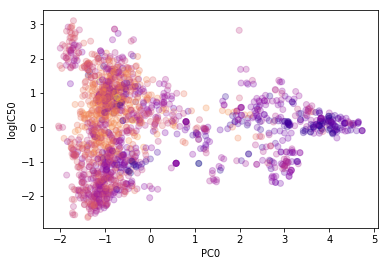

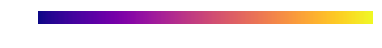

In [21]:
plt.xlabel('PC0')
plt.ylabel('logIC50')
plot_scatter_colormap(pc[:,0], pc[:,1],log_ic50.values)

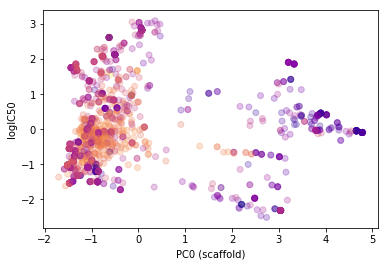

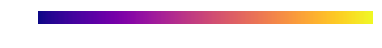

In [22]:
plt.xlabel('PC0 (scaffold)')
plt.ylabel('logIC50')
plot_scatter_colormap(pc_scaffold[:,0], pc_scaffold[:,1],log_ic50.values)

## Principal component regression analysis

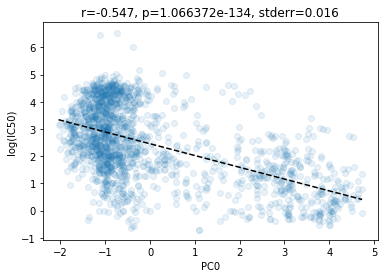

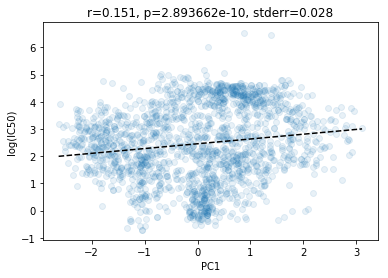

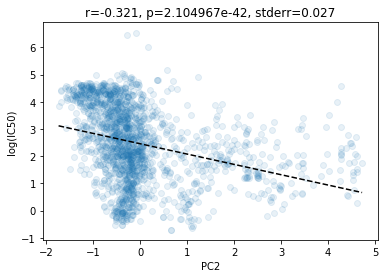

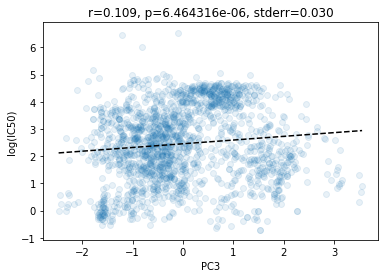

In [23]:
for i in range(4):
    plt.figure()
    plot_linear_regression(pc[:,i], log_ic50)
    plt.xlabel('PC%d' % i)
    plt.ylabel('log(IC50)')

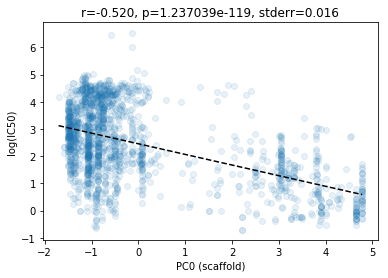

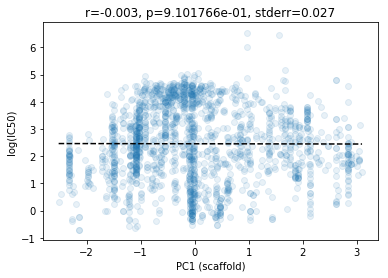

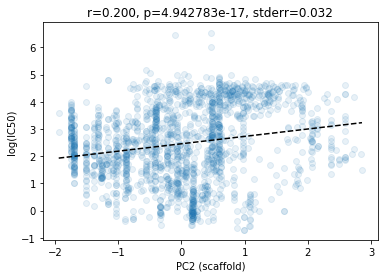

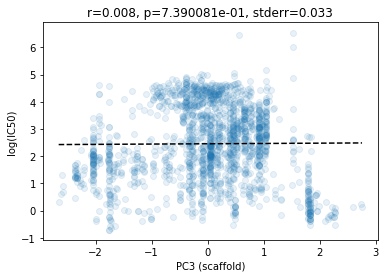

In [24]:
for i in range(4):
    plt.figure()
    plot_linear_regression(pc_scaffold[:,i], log_ic50)
    plt.xlabel('PC%d (scaffold)' % i)
    plt.ylabel('log(IC50)')

## Linear regression on whole fingerprint

In [218]:
lr = LinearRegression()
lr.fit(fps, log_ic50)
r2 = lr.score(fps, log_ic50)
np.sqrt(r2)

0.9642369099223769

In [237]:
lr = LinearRegression()
lr.fit(scaffold_fps, log_ic50)
r2 = lr.score(scaffold_fps, log_ic50)
np.sqrt(r2)

0.9060400707565774

In [68]:
rs = []
for nc in tqdm_notebook(range(1,513)):
    lr = LinearRegression()
    lr.fit(pc[:,:nc], log_ic50)
    r2 = lr.score(pc[:,:nc], log_ic50)
    rs.append(np.sqrt(r2))

In [69]:
rs_scaffold = []
for nc in tqdm_notebook(range(1,513)):
    lr = LinearRegression()
    lr.fit(pc_scaffold[:,:nc], log_ic50)
    r2 = lr.score(pc_scaffold[:,:nc], log_ic50)
    rs_scaffold.append(np.sqrt(r2))

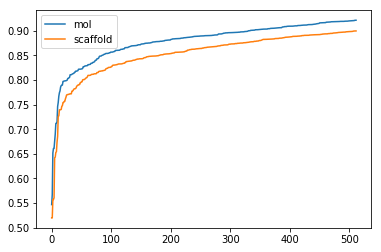

In [70]:
plt.plot(np.asarray(rs)**1, label='mol')
plt.plot(np.asarray(rs_scaffold)**1, label='scaffold')
plt.legend()

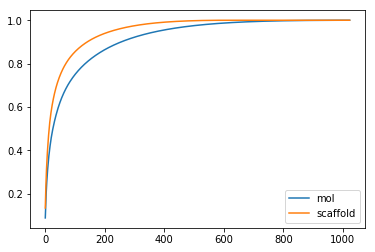

In [71]:
plt.plot(list(accumulate(pca.explained_variance_ratio_)), label='mol')
plt.plot(list(accumulate(pca_scaffold.explained_variance_ratio_)), label='scaffold')
plt.legend()

In [273]:
len(df_era), len(set(df_era.std_smiles)), len(set(df_era.std_morgan_fp)), len(set(df_era.scaffold_smiles)), len(set(df_era.scaffold_morgan_fp))

(1719, 1719, 1622, 699, 661)